In [1]:
import os
from collections import Counter, OrderedDict

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import functional as T

from torchmetrics import Accuracy

import numpy as np
import matplotlib.pyplot as plt

import cv2

import PIL

from tqdm.auto import tqdm

In [2]:
device = torch.device(
  "cuda" if torch.cuda.is_available() else
  "mps" if torch.backends.mps.is_available() else
  "cpu")
device

device(type='mps')

## Dataset Preparation and Visualization

[The PASCAL Visual Object Classes Challenge 2007](http://host.robots.ox.ac.uk/pascal/VOC/voc2007/)

In [3]:
trainval_dataset = datasets.VOCDetection(
  root="data",
  download=True,
  year="2007",
  image_set="trainval"
)

test_dataset = datasets.VOCDetection(
  root="data",
  download=True,
  year="2007",
  image_set="test"
)

Using downloaded and verified file: data/VOCtrainval_06-Nov-2007.tar
Extracting data/VOCtrainval_06-Nov-2007.tar to data
Using downloaded and verified file: data/VOCtest_06-Nov-2007.tar
Extracting data/VOCtest_06-Nov-2007.tar to data


In [4]:
image, target = trainval_dataset[0]
image.size, target

((500, 375),
 {'annotation': {'folder': 'VOC2007',
   'filename': '000005.jpg',
   'source': {'database': 'The VOC2007 Database',
    'annotation': 'PASCAL VOC2007',
    'image': 'flickr',
    'flickrid': '325991873'},
   'owner': {'flickrid': 'archintent louisville', 'name': '?'},
   'size': {'width': '500', 'height': '375', 'depth': '3'},
   'segmented': '0',
   'object': [{'name': 'chair',
     'pose': 'Rear',
     'truncated': '0',
     'difficult': '0',
     'bndbox': {'xmin': '263', 'ymin': '211', 'xmax': '324', 'ymax': '339'}},
    {'name': 'chair',
     'pose': 'Unspecified',
     'truncated': '0',
     'difficult': '0',
     'bndbox': {'xmin': '165', 'ymin': '264', 'xmax': '253', 'ymax': '372'}},
    {'name': 'chair',
     'pose': 'Unspecified',
     'truncated': '1',
     'difficult': '1',
     'bndbox': {'xmin': '5', 'ymin': '244', 'xmax': '67', 'ymax': '374'}},
    {'name': 'chair',
     'pose': 'Unspecified',
     'truncated': '0',
     'difficult': '0',
     'bndbox': {'x

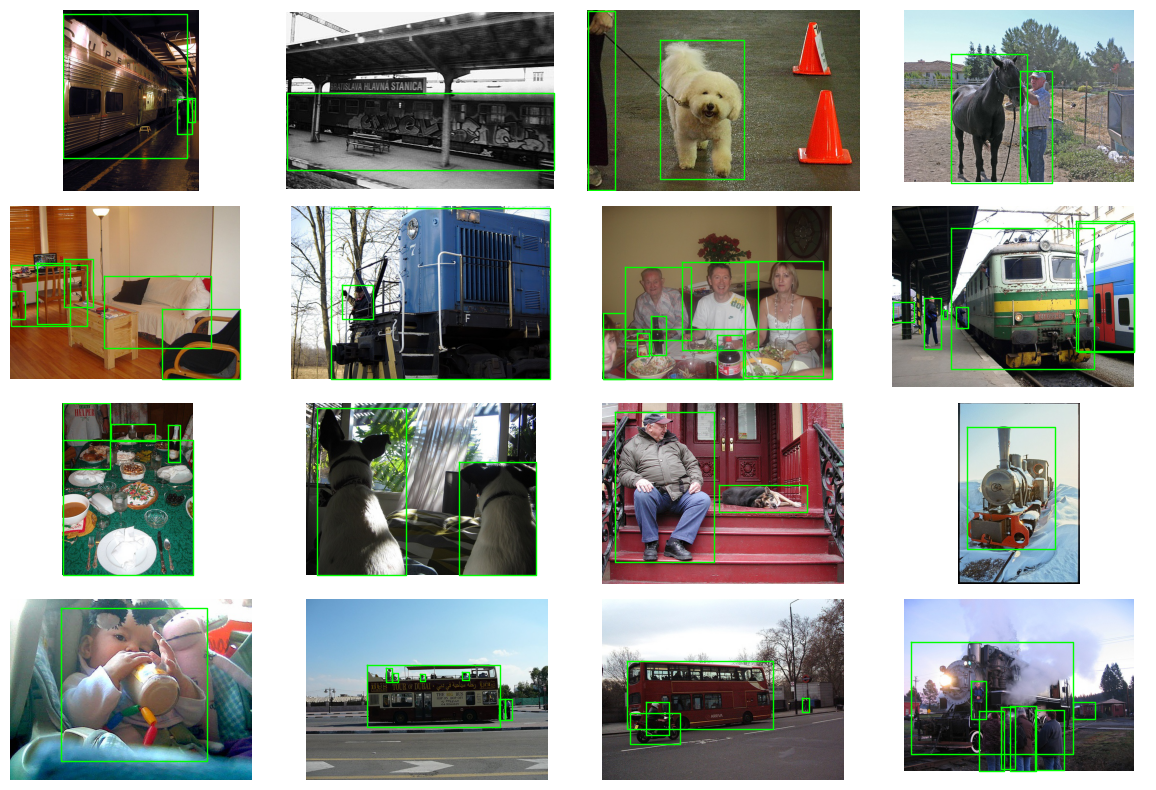

In [5]:
def extract_bndbox_coords(obj):
  xmin = int(obj["bndbox"]["xmin"])
  ymin = int(obj["bndbox"]["ymin"])
  xmax = int(obj["bndbox"]["xmax"])
  ymax = int(obj["bndbox"]["ymax"])

  return xmin, ymin, xmax, ymax

def extract_name(obj):
  return obj["name"]

def plot_sample(image, target):
  plt.imshow(image)

  for obj in target["annotation"]["object"]:
    xmin, ymin, xmax, ymax = extract_bndbox_coords(obj)
    plt.plot(
      [xmin, xmax, xmax, xmin, xmin],
      [ymin, ymin, ymax, ymax, ymin],
      color="lime",
      linewidth=1
    )

def plot_random_samples(dataset, n_rows=4, n_cols=4):
  n_samples = n_rows * n_cols

  sample_indices = np.random.choice(len(dataset), n_samples)

  plt.figure(figsize=(12, 8))

  for i in range(n_samples):
    image, target = dataset[sample_indices[i]]

    plt.subplot(n_rows, n_cols, i + 1)
    plot_sample(image, target)
    plt.axis(False)

  plt.tight_layout()
  plt.show()

plot_random_samples(trainval_dataset)

In [6]:
class_counter = Counter(extract_name(obj) for _, target in trainval_dataset for obj in target["annotation"]["object"])
class_counter

Counter({'person': 5447,
         'car': 1644,
         'chair': 1432,
         'bottle': 634,
         'pottedplant': 625,
         'bird': 599,
         'dog': 538,
         'sofa': 425,
         'bicycle': 418,
         'horse': 406,
         'boat': 398,
         'motorbike': 390,
         'cat': 389,
         'tvmonitor': 367,
         'cow': 356,
         'sheep': 353,
         'aeroplane': 331,
         'train': 328,
         'diningtable': 310,
         'bus': 272})

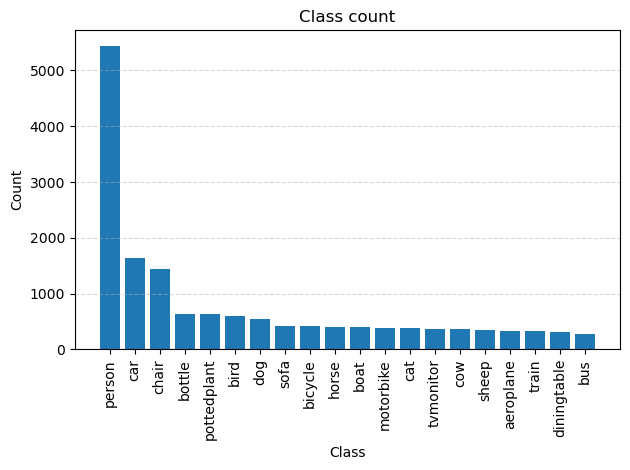

In [7]:
sorted_items = sorted(class_counter.items(), key=lambda x: x[1], reverse=True)

classes = [cname for cname, _ in sorted_items]
counts = [count for _, count in sorted_items]

plt.bar(classes, counts)

plt.title("Class count")
plt.xlabel("Class")
plt.ylabel("Count")

plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.xticks(np.arange(len(classes)), classes, rotation=90)

plt.tight_layout()
plt.show()

In [8]:
def calc_aspect_ratio(obj):
  xmin, ymin, xmax, ymax = extract_bndbox_coords(obj)

  width = xmax - xmin
  height = ymax - ymin

  return width / height

aspect_ratios = np.array([calc_aspect_ratio(obj) for _, target in trainval_dataset for obj in target["annotation"]["object"]])
aspect_ratios

array([0.4765625 , 0.81481481, 0.47692308, ..., 0.51794872, 3.06666667,
       0.94721408])

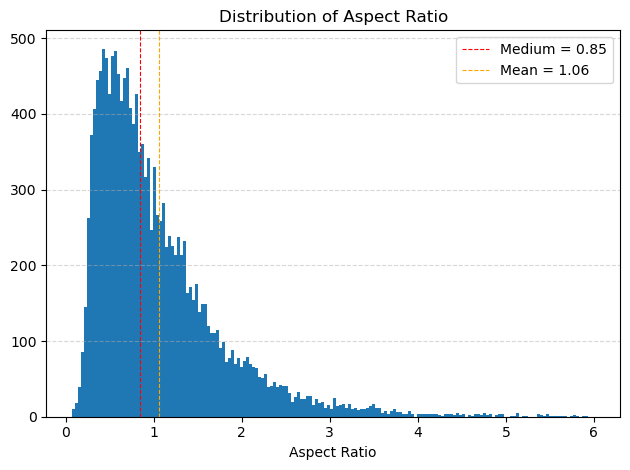

In [9]:
def calc_medium(arr):
  medium_idx = arr.argsort()[len(arr) // 2]
  return arr[medium_idx]

aspect_ratio_min = aspect_ratios.min()
aspect_ratio_max = aspect_ratios.max()

aspect_ratio_medium = calc_medium(aspect_ratios)

aspect_ratio_mean = aspect_ratios.mean()

plt.hist(aspect_ratios, bins=np.linspace(aspect_ratio_min, 6, 175))

plt.title("Distribution of Aspect Ratio")
plt.xlabel("Aspect Ratio")

plt.axvline(
  aspect_ratio_medium,
  color="red", linestyle="--", linewidth=0.8,
  label=f"Medium = {aspect_ratio_medium:.2f}"
)
plt.axvline(
  aspect_ratio_mean,
  color="orange", linestyle="--", linewidth=0.8,
  label=f"Mean = {aspect_ratio_mean:.2f}"
)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
def pil_to_bgr(pil_img):
  return cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)

def bgr_to_rgb(bgr_img):
  return cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)

def bgr_to_pil(bgr_img):
  return PIL.Image.fromarray(bgr_to_rgb(bgr_img))

In [ ]:
def sample_region_proposals(image, n=10, mode="quality"):
  image = pil_to_bgr(image)

  ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
  ss.setBaseImage(image)
  
  if mode == "fast":
    ss.switchToSelectiveSearchQuality()
  elif mode == "quality":
    ss.switchToSelectiveSearchQuality()

  rects = ss.process()

  region_proposals = []
  boxes = []

  for x, y, w, h in rects[:n]:
    region_proposals.append(bgr_to_pil(image[y:y+h, x:x+w]))
    boxes.append((x, y, x+w-1, y+h-1))

  return region_proposals, boxes

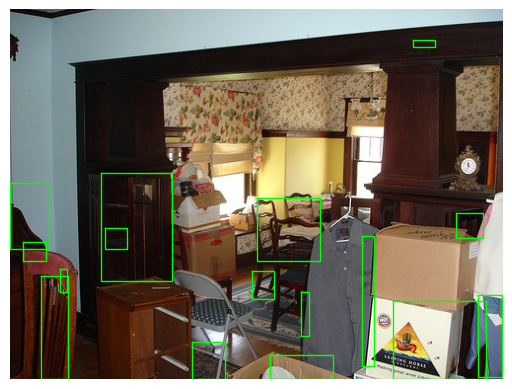

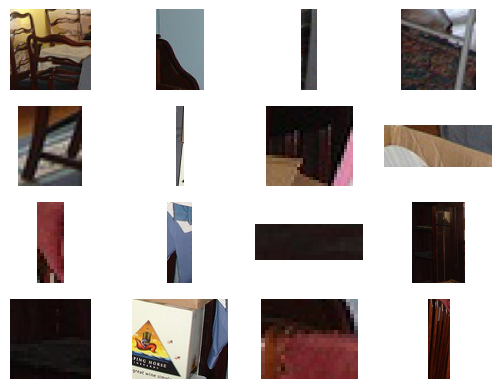

In [12]:
def plot_bndbox(box):
  xmin, ymin, xmax, ymax = box
  plt.plot(
    [xmin, xmax, xmax, xmin, xmin],
    [ymin, ymin, ymax, ymax, ymin],
    color="lime", linewidth=1
  )

image, _ = trainval_dataset[0]
region_proposals, boxes = sample_region_proposals(image, n=16, mode="quality")

plt.imshow(image)
plt.axis(False)

for box in boxes:
  plot_bndbox(box)

plt.show()

for i, img in enumerate(region_proposals):
  plt.subplot(4, 4, i + 1)
  plt.imshow(img)
  plt.axis(False)
  plt.show

In [13]:
image, _ = trainval_dataset[0]
region_proposals, boxes = sample_region_proposals(image, n=2000, mode="quality")

# 3.0-3.5s to calculate 2000 region proposals